# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [386]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [387]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [388]:
import torch

# Part 1: Training a Single-step Denoising UNet

## Implementing Simple and Composed Ops

In [389]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=7),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2.forward(self.conv1.forward(x))


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = DownConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.convblock.forward(self.downconv.forward(x))


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.convblock.forward(self.upconv.forward(x))

## Implementing Unconditional UNet

In [390]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens
        self.conv_block_1 = ConvBlock(1, self.num_hiddens)
        self.down_block_1 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.down_block_2 = DownBlock(self.num_hiddens, 2 * self.num_hiddens)
        self.flatten_1 = Flatten()
        self.unflatten_1 = Unflatten(2 * self.num_hiddens)
        self.up_block_1 = UpBlock(4 * self.num_hiddens, self.num_hiddens)
        self.up_block_2 = UpBlock(2 * self.num_hiddens, self.num_hiddens)
        self.conv_block_2 = ConvBlock(2 * self.num_hiddens, self.num_hiddens)
        self.final = nn.Conv2d(in_channels=self.num_hiddens, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x_1 = self.conv_block_1.forward(x)
        x_2 = self.down_block_1.forward(x_1)
        x_3 = self.down_block_2.forward(x_2)
        x_4 = self.flatten_1.forward(x_3)
        x_5 = self.unflatten_1.forward(x_4)
        x_6 = torch.cat((x_3, x_5), dim = -3)
        x_7 = self.up_block_1.forward(x_6)
        x_8 = torch.cat((x_2, x_7), dim = -3)
        x_9 = self.up_block_2.forward(x_8)
        x_10 = torch.cat((x_1, x_9), dim = -3)
        x_11 = self.conv_block_2.forward(x_10)
        x_12 = self.final.forward(x_11)
        return x_12

In [391]:
import numpy as np
import mediapy as media

In [497]:
train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

images = next(iter(train_loader))[0][:5]

indices = np.arange(0, 1.2, .2)

for i in images:
  media.show_images([i[0] + torch.randn_like(i[0]) * index for index in indices])

,,,,,


,,,,,


,,,,,


,,,,,


,,,,,


In [499]:
import torch.optim as optim
model = UnconditionalUNet(1, 128)
model = model.to(torch.device("cuda"))
criterion = nn.MSELoss()  # Use MSE loss instead of CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model

def add_noise(image, noise_factor=0.5):
    """Add Gaussian noise to an image."""
    noise = torch.randn_like(image) * noise_factor  # Generate random noise with normal distribution
    noisy_image = image + noise  # Add noise to the original image
    # Clip values to make sure they stay within the valid range [0, 1]
    noisy_image = torch.clamp(noisy_image, -1.0, 1.0)
    return noisy_image

epochs = 5
losses = []
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(torch.device("cuda"))
        # Convert labels to float (MSE expects float targets)
        noisy_images = add_noise(images).to(torch.device("cuda"))

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass: Get the denoised image from the model
        denoised_images = model(noisy_images)

        # Compute the MSE loss between the original and denoised images
        loss = criterion(denoised_images, images)  # Compare denoised image to the original (clean) image

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        losses.append(loss.item())
    print('done with epoch ' + str(epoch))
    if epoch == 0 or epoch == 4:
        model.eval()
        images = next(iter(test_loader))[0][:5]
        noisy_images = add_noise(images).to(torch.device("cuda"))
        denoised = model(noisy_images)
        for i in range(5):
          media.show_images([images[i][0], noisy_images[i][0].cpu(), denoised[i][0].cpu().detach().numpy()])

done with epoch 0


,,


,,


,,


,,


,,


done with epoch 1
done with epoch 2
done with epoch 3
done with epoch 4


,,


,,


,,


,,


,,


In [ ]:
model.eval()
images = next(iter(test_loader))[0][:5]
noisy_images = add_noise(images).to(torch.device("cuda"))
denoised = model(noisy_images)
for i in range(5):
  media.show_images([images[i][0], noisy_images[i][0].cpu(), denoised[i][0].cpu().detach().numpy()])

,,


,,


,,


,,


,,


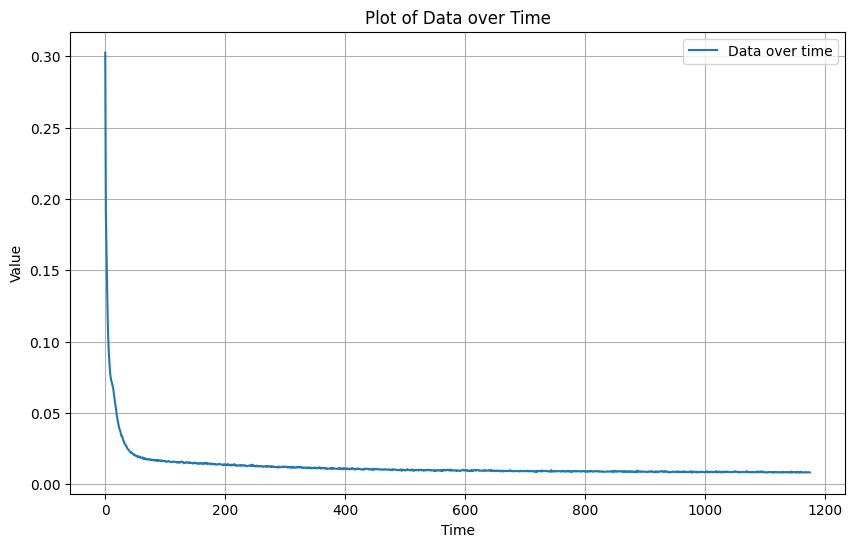

In [10]:
time = np.arange(len(losses))  # This will create an array [0, 1, 2, ..., 1173]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, losses, label='Data over time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Plot of Data over Time')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
model.eval()
images = next(iter(test_loader))[0][5:6]
indices = [.0, .2, .4, .5, .6, .8, 1.0]
curImages = []
denoised = []
for image in images:
  for i in indices:
    curImage = add_noise(image, noise_factor = i).to(torch.device("cuda"))
    curImages.append(curImage)
  curImages = torch.stack(curImages)
  denoised = model(curImages)
  media.show_images([curImages[i][0].cpu() for i in range(len(curImages))])
  media.show_images([denoised[i][0].cpu().detach().numpy() for i in range(len(denoised))])

,,,,,,


,,,,,,


# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [500]:
import random
time_criterion = nn.MSELoss()

In [501]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.first_block = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU()
        )
        self.second_block = nn.Linear(out_channels, out_channels)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.first_block(x)
        x = self.second_block(x)
        return x


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens
        self.conv_block_1 = ConvBlock(1, self.num_hiddens)
        self.down_block_1 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.down_block_2 = DownBlock(self.num_hiddens, 2 * self.num_hiddens)
        self.flatten_1 = Flatten()
        self.unflatten_1 = Unflatten(2 * self.num_hiddens)
        self.fc_block_1 = FCBlock(1, 2 * num_hiddens)
        self.up_block_1 = UpBlock(4 * self.num_hiddens, self.num_hiddens)
        self.fc_block_2 = FCBlock(1, num_hiddens)
        self.up_block_2 = UpBlock(2 * self.num_hiddens, self.num_hiddens)
        self.conv_block_2 = ConvBlock(2 * self.num_hiddens, self.num_hiddens)
        self.final = nn.Conv2d(in_channels=self.num_hiddens, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x_1 = self.conv_block_1.forward(x)
        x_2 = self.down_block_1.forward(x_1)
        x_3 = self.down_block_2.forward(x_2)
        x_4 = self.flatten_1.forward(x_3)
        x_5 = self.unflatten_1.forward(x_4)
        y_1 = self.fc_block_1.forward(t.to(torch.device("cuda")))
        y_1 = y_1.unsqueeze(2).unsqueeze(3)
        x_5 = x_5 + y_1
        x_6 = torch.cat((x_3, x_5), dim = 1)
        x_7 = self.up_block_1.forward(x_6)
        y_2 = self.fc_block_2.forward(t.to(torch.device("cuda")))
        y_2 = y_2.unsqueeze(2).unsqueeze(3)
        x_7 = x_7 + y_2
        x_8 = torch.cat((x_2, x_7), dim = 1)
        x_9 = self.up_block_2.forward(x_8)
        x_10 = torch.cat((x_1, x_9), dim = 1)
        x_11 = self.conv_block_2.forward(x_10)
        x_12 = self.final.forward(x_11)
        return x_12

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [502]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    random_integers = [random.randint(0, num_ts) for _ in range(x_0.shape[0])]
    random_integers = np.array(random_integers).reshape(x_0.shape[0], 1)
    error = torch.randn_like(x_0)
    cur_alpha = ddpm_schedule["alpha_bars"][random_integers]
    cur_alpha = torch.Tensor(cur_alpha).to("cuda")
    cur_alpha = cur_alpha.unsqueeze(2).unsqueeze(3)
    x_t = torch.sqrt(cur_alpha) * x_0 + torch.sqrt(1 - cur_alpha) * error
    predicted_error = unet.forward(x_t, torch.Tensor(random_integers / num_ts))
    return time_criterion(predicted_error, error)

In [503]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas = np.linspace(beta1, beta2, num_ts + 1)
    alphas = 1 - betas
    alpha_bars = np.cumprod(alphas)
    return {"betas": torch.Tensor(betas).to(torch.device("cuda")), "alphas": torch.Tensor(alphas).to(torch.device("cuda")), "alpha_bars": torch.Tensor(alpha_bars).to(torch.device("cuda"))}


In [504]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    x_t = torch.randn(img_wh).to(torch.device("cuda"))
    media.show_image(x_t.cpu().detach().numpy()[0][0])
    for t in range(num_ts, 1, -1):
        if t > 1:
            z = torch.randn_like(x_t).to(torch.device("cuda"))
        else:
            z = 0
        alpha_cumprod = ddpm_schedule["alpha_bars"][t]
        alpha_cumprod_prev = ddpm_schedule["alpha_bars"][t - 1]
        beta = ddpm_schedule["betas"][t]
        alpha_cur = ddpm_schedule["alphas"][t]
        x_0_hat = (1 / torch.sqrt(alpha_cumprod)) * (x_t - torch.sqrt(1 - alpha_cumprod) * unet.forward(x_t, torch.Tensor(np.array([t / num_ts]).reshape(1, 1)).to(torch.device("cuda"))))
        x_t = (torch.sqrt(alpha_cumprod_prev) * beta / (1 - alpha_cumprod)) * x_0_hat + (torch.sqrt(alpha_cur) * (1 - alpha_cumprod_prev) / (1 - alpha_cumprod)) * x_t + torch.sqrt(beta) * z
    return x_t
        
    

In [505]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        schedule = {
            k: torch.Tensor(v).to("cuda")
            for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items()
        }
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

In [506]:
new_train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
new_test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())

# Create DataLoader for training and testing
new_train_loader = DataLoader(new_train_dataset, batch_size=128, shuffle=True)
new_test_loader = DataLoader(new_test_dataset, batch_size=128, shuffle=False)

In [507]:
import torch.optim as optim
unet = TimeConditionalUNet(1, 10, 64).to(torch.device("cuda"))
model = DDPM(unet)
model = model.to(torch.device("cuda"))
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=pow(.1, (1.0 / num_epochs)))
# Train the model

In [508]:
losses = []
for epoch in range(num_epochs):
    for images, labels in new_train_loader:
        images = images.to(torch.device("cuda"))
        images = torch.Tensor(images)
        # Convert labels to float (MSE expects float targets)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass: Get the denoised image from the model
        loss = model(images)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('done with epoch ' + str(epoch))
    if epoch in [0, 4, 9, 14, 19]:
        images = [model.sample((1, 1, 28, 28)).cpu().detach() for i in range(5)]
        media.show_images([i[0][0] for i in images])
    scheduler.step()

done with epoch 0


""


""


""


""


""


,,,,


done with epoch 1
done with epoch 2
done with epoch 3
done with epoch 4


""


""


""


""


""


,,,,


done with epoch 5
done with epoch 6
done with epoch 7
done with epoch 8
done with epoch 9


""


""


""


""


""


,,,,


done with epoch 10
done with epoch 11
done with epoch 12
done with epoch 13
done with epoch 14


""


""


""


""


""


,,,,


done with epoch 15
done with epoch 16
done with epoch 17
done with epoch 18
done with epoch 19


""


""


""


""


""


,,,,


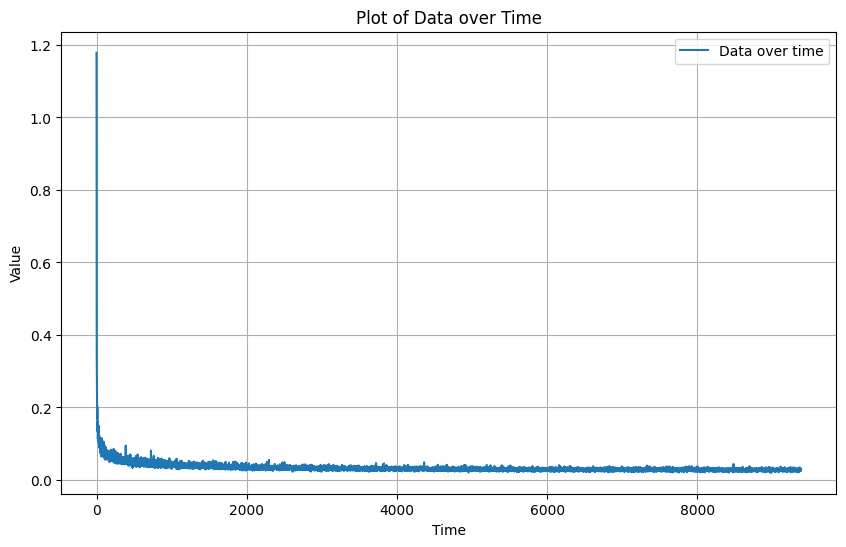

In [509]:
time = np.arange(len(losses))  # This will create an array [0, 1, 2, ..., 1173]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, losses, label='Data over time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Plot of Data over Time')
plt.grid(True)
plt.legend()
plt.show()

### Implementing class-conditioned UNet

In [510]:
class_loss = nn.MSELoss()

In [511]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes
        self.conv_block_1 = ConvBlock(1, self.num_hiddens)
        self.down_block_1 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.down_block_2 = DownBlock(self.num_hiddens, 2 * self.num_hiddens)
        self.flatten_1 = Flatten()
        self.unflatten_1 = Unflatten(2 * self.num_hiddens)
        self.fc_block_1 = FCBlock(1, 2 * num_hiddens)
        self.fc_block_1_class = FCBlock(self.num_classes, 2 * num_hiddens)
        self.up_block_1 = UpBlock(4 * self.num_hiddens, self.num_hiddens)
        self.fc_block_2 = FCBlock(1, num_hiddens)
        self.fc_block_2_class = FCBlock(self.num_classes, num_hiddens)
        self.up_block_2 = UpBlock(2 * self.num_hiddens, self.num_hiddens)
        self.conv_block_2 = ConvBlock(2 * self.num_hiddens, self.num_hiddens)
        self.final = nn.Conv2d(in_channels=self.num_hiddens, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x_1 = self.conv_block_1.forward(x)
        x_2 = self.down_block_1.forward(x_1)
        x_3 = self.down_block_2.forward(x_2)
        x_4 = self.flatten_1.forward(x_3)
        x_5 = self.unflatten_1.forward(x_4)
        y_1 = self.fc_block_1.forward(t.to(torch.device("cuda")))
        y_1 = y_1.unsqueeze(2).unsqueeze(3)
        y_1_class = self.fc_block_1_class.forward(c.to(torch.device("cuda")))
        y_1_class = y_1_class.unsqueeze(2).unsqueeze(3)
        x_5 = y_1_class * x_5 + y_1
        x_6 = torch.cat((x_3, x_5), dim = 1)
        x_7 = self.up_block_1.forward(x_6)
        y_2 = self.fc_block_2.forward(t.to(torch.device("cuda")))
        y_2 = y_2.unsqueeze(2).unsqueeze(3)
        y_2_class = self.fc_block_2_class.forward(c.to(torch.device("cuda")))
        y_2_class = y_2_class.unsqueeze(2).unsqueeze(3)
        x_7 = y_2_class * x_7 + y_2
        x_8 = torch.cat((x_2, x_7), dim = 1)
        x_9 = self.up_block_2.forward(x_8)
        x_10 = torch.cat((x_1, x_9), dim = 1)
        x_11 = self.conv_block_2.forward(x_10)
        x_12 = self.final.forward(x_11)
        return x_12

In [512]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    c_encoded = np.zeros((c.shape[0], 10))
    for i in range(c.shape[0]):
        probability_gen = np.random.random()
        if probability_gen > .1:
            c_encoded[i][c[i]] = 1
    random_integers = [random.randint(0, num_ts) for _ in range(x_0.shape[0])]
    random_integers = np.array(random_integers).reshape(x_0.shape[0], 1)
    error = torch.randn_like(x_0)
    cur_alpha = ddpm_schedule["alpha_bars"][random_integers]
    cur_alpha = torch.Tensor(cur_alpha).to("cuda")
    cur_alpha = cur_alpha.unsqueeze(2).unsqueeze(3)
    x_t = torch.sqrt(cur_alpha) * x_0 + torch.sqrt(1 - cur_alpha) * error
    predicted_error = unet.forward(x_t, torch.Tensor(c_encoded), torch.Tensor(random_integers / num_ts))
    return class_loss(predicted_error, error)

In [513]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    x_t = torch.randn(img_wh).to(torch.device("cuda"))
    c_encoded = np.zeros((c.shape[0], 10))
    for i in range(c.shape[0]):
        c_encoded[i][int(c[i])] = 1
    for t in range(num_ts, 1, -1):
        if t > 1:
            z = torch.randn_like(x_t).to(torch.device("cuda"))
        else:
            z = 0
        alpha_cumprod = ddpm_schedule["alpha_bars"][t]
        alpha_cumprod_prev = ddpm_schedule["alpha_bars"][t - 1]
        beta = ddpm_schedule["betas"][t]
        alpha_cur = ddpm_schedule["alphas"][t]
        forward_t = torch.Tensor(np.array([t / num_ts]).reshape(1, 1)).to(torch.device("cuda"))
        e_u = unet.forward(x_t, torch.Tensor(np.zeros((c.shape[0], 10))).to(torch.device("cuda")), forward_t)
        e_c = unet.forward(x_t, torch.Tensor(c_encoded).to(torch.device("cuda")), forward_t)
        e = e_u + guidance_scale * (e_c - e_u)
        x_0_hat = (1 / torch.sqrt(alpha_cumprod)) * (x_t - torch.sqrt(1 - alpha_cumprod) * e)
        x_t = (torch.sqrt(alpha_cumprod_prev) * beta / (1 - alpha_cumprod)) * x_0_hat + (torch.sqrt(alpha_cur) * (1 - alpha_cumprod_prev) / (1 - alpha_cumprod)) * x_t + torch.sqrt(beta) * z
    return x_t

In [514]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

In [515]:
import torch.optim as optim
unet = ClassConditionalUNet(1, 10, 64).to(torch.device("cuda"))
model = DDPM(unet)
model = model.to(torch.device("cuda"))
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=pow(.1, (1.0 / num_epochs)))

In [516]:
losses = []
for epoch in range(num_epochs):
    for images, labels in new_train_loader:
        images = images.to(torch.device("cuda"))
        images = torch.Tensor(images)
        labels = labels.to(torch.device("cuda"))
        # Convert labels to float (MSE expects float targets)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass: Get the denoised image from the model
        loss = model(images, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('done with epoch ' + str(epoch))
    if epoch in [0, 4, 9, 14, 19]:
        images = [model.sample(torch.Tensor(np.array([i])), (1, 1, 28, 28)).cpu().detach() for i in range(10)]
        media.show_images([i[0][0] for i in images])
        images = [model.sample(torch.Tensor(np.array([i])), (1, 1, 28, 28)).cpu().detach() for i in range(10)]
        media.show_images([i[0][0] for i in images])
        images = [model.sample(torch.Tensor(np.array([i])), (1, 1, 28, 28)).cpu().detach() for i in range(10)]
        media.show_images([i[0][0] for i in images])
        images = [model.sample(torch.Tensor(np.array([i])), (1, 1, 28, 28)).cpu().detach() for i in range(10)]
        media.show_images([i[0][0] for i in images])
    scheduler.step()

done with epoch 0


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


done with epoch 1
done with epoch 2
done with epoch 3
done with epoch 4


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


done with epoch 5
done with epoch 6
done with epoch 7
done with epoch 8
done with epoch 9


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


done with epoch 10
done with epoch 11
done with epoch 12
done with epoch 13
done with epoch 14


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


done with epoch 15
done with epoch 16
done with epoch 17
done with epoch 18
done with epoch 19


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


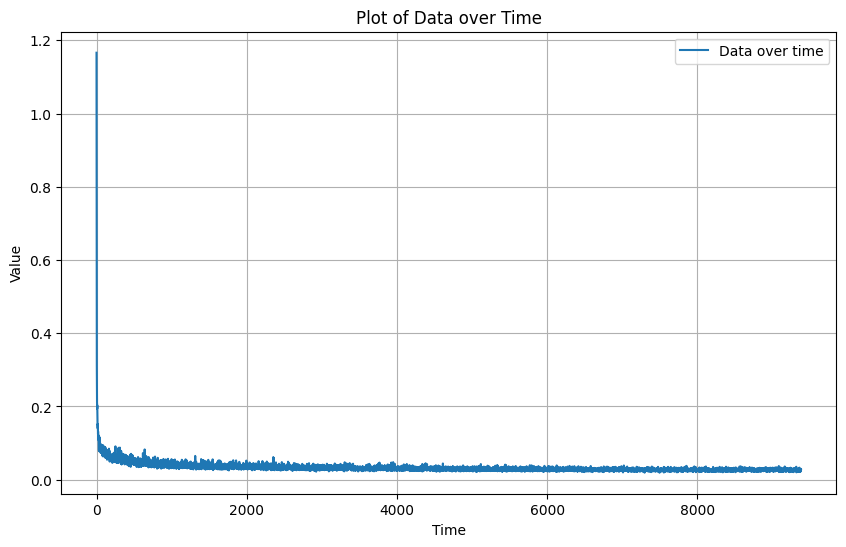

In [517]:
time = np.arange(len(losses))  # This will create an array [0, 1, 2, ..., 1173]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, losses, label='Data over time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Plot of Data over Time')
plt.grid(True)
plt.legend()
plt.show()